In [1]:
import tensorflow.keras
tensorflow.keras.__version__

'2.1.6-tf'

# Классификация отзывов к фильмам: пример бинарной классификации

Классификация по двум классам, или бинарная классификация, является едва ли
не самой распространенной задачей машинного обучения. В этом примере вы научитесь классифицировать отзывы к фильмам на положительные и отрицательные,
опираясь на текст отзывов.

## The IMDB dataset
Вы будете работать с набором данных IMDB: множеством из 50 000 самых разных
отзывов к кинолентам в интернет-базе фильмов (Internet Movie Database). Набор
разбит на 25 000 обучающих и 25 000 контрольных отзывов, каждый набор на 50 %
состоит из отрицательных и на 50 % из положительных отзывов.
Для чего использовать два набора — обучающий и контрольный? Потому что
никогда не следует тестировать модель машинного обучения на тех же данных,
которые использовались для ее обучения! Если модель прекрасно справляется с об-
учающими данными, это еще не значит, что она так же хорошо будет справляться
с данными, которые прежде никогда не видела; и ваша задача — создать модель,
качественно распознающую новые данные (вы уже знаете, к каким классам принадлежат обучающие данные, и совершенно понятно, что вам не нужна модель,
классифицирующая их). Например, возможно, что ваша модель просто запомнит
соответствия между обучающими образцами и их целями, что совершенно бесполезно для задачи предсказания по данным, которые модель никогда не видела
прежде. Подробнее этот вопрос мы обсудим в следующей главе.
Подобно MNIST, набор данных IMDB поставляется в составе Keras. Он уже готов
к использованию: отзывы (последовательности слов) преобразованы в последова-
тельности целых чисел, каждое из которых определяет позицию слова в словаре.
Код загружает набор данных (при первом запуске на ваш компьютер
будет загружено примерно 80 Мбайт данных).

In [2]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 7s 0us/step



Аргумент `num_words=10000` означает, что в обучающих данных будет сохранено
только 10 000 слов, наиболее часто встречающихся в обучающем наборе отзывов.
Редкие слова будут отброшены. Это позволит вам работать с вектором управляемого размера.

Переменные `train_data` и  `test_data`  — это списки отзывов; каждый отзыв — это
список индексов слов (кодированное представление последовательности слов).
Переменные `train_labels` и  `test_labels`  — это списки нулей и единиц, где нули
соответствуют отрицательным отзывам, а единицы — положительным:

In [28]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

Поскольку мы ограничили себя 10 000 наиболее употребительных слов, в наборе
отсутствуют индексы больше 10 000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

Чтобы вам было понятнее, ниже показано декодирование одного из отзывов в последовательность слов на английском языке:

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1654784/1641221 [==============================] - 1s 0us/step


In [7]:
decoded_review

u"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you t

## Подготовка данных


Нельзя передать списки целых чисел непосредственно в нейронную сеть. Поэтому
мы должны преобразовать их в тензоры. Сделать это можно двумя способами:

* Привести все списки к одинаковой длине, преобразовать их в тензоры целых
чисел с формой (образцы, индексы_слов) и затем передать их в первый слой
сети, способный обрабатывать такие целочисленные тензоры (слой Embedding ,
о котором подробнее мы поговорим далее).
* Выполнить прямое кодирование списков в векторы нулей и единиц. Это может
означать, например, преобразование последовательности `[3, 5]` в 10 000-мерный
вектор, все элементы которого содержат нули, кроме элементов с индексами
3 и 5, которые содержат единицы. Затем их можно передать в первый слой сети типа `Dense` , способный обрабатывать векторизованные данные с вещественными
числами.

Мы пойдем по второму пути, с векторизованными данными, которые создадим
вручную, чтобы было понятнее.

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Вот как теперь выглядят образцы:

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Нам также нужно векторизовать метки, что делается очень просто:

In [10]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Теперь данные готовы к передаче в нейронную сеть

## Конструирование сети


Входные данные представлены векторами, а метки — скалярами (единицами и ну-
лями): это самый простой набор данных, какой можно встретить. С задачами этого
вида прекрасно справляются сети, организованные как простой стек полносвязных
( Dense ) слоев с операцией активации relu : Dense(16, activation='relu') .
Аргумент (16), передаваемый каждому слою Dense , — это число скрытых нейронов
слоя. Скрытый нейрон (hidden unit) — это измерение в пространстве представлений
слоя. Как рассказывалось в главе 2, каждый слой Dense с операцией активации relu
реализует следующую цепочку операций с тензорами:

`output = relu(dot(W, input) + b)`

Наличие 16 скрытых нейронов означает, что весовая матрица W будет иметь форму
(input_dimension, 16) : скалярное произведение на W спроецирует входные данные
в 16-мерное пространство представлений (затем будет произведено сложение
с вектором смещений b и выполнена операция relu ). Размерность пространства
представлений можно интерпретировать как «степень свободы нейронной сети
при изучении внутренних представлений». Большее количество скрытых нейронов (большая размерность пространства представлений) позволяет сети обучаться
на более сложных представлениях, но при этом увеличивается вычислительная
стоимость сети, что может привести к выявлению нежелательных шаблонов (шаблонов, которые могут повысить качество классификации обучающих данных, но
не контрольных).
В отношении такого стека слоев Dense требуется принять два важных архитектурных решения:

* сколько слоев использовать;
* сколько скрытых нейронов выбрать для каждого слоя.

Промежуточные слои будут использовать операцию relu в качестве функции
активации, а последний слой будет использовать сигмоидную функцию активации и выводить вероятность (оценку вероятности, между 0 и 1 того, что образец
относится к классу «1», то есть насколько он близок к положительному отзыву).
Функция relu (rectified linear unit — блок линейной ректификации) использует-
ся для преобразования отрицательных значений в ноль (рис. 3.4), а сигмоидная
функция рассредоточивает произвольные значения по интервалу [0, 1] (рис. 3.5),
возвращая значения, которые можно интерпретировать как вероятность.

На рис. показано, как выглядит сеть. 

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

Реализация этой сети с использованием Keras напоминает пример MNIST, который мы видели раньше.

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Наконец, нужно выбрать функцию потерь и оптимизатор. Так как перед нами стоит
задача бинарной классификации и результатом работы сети является вероятность
(наша сеть заканчивается одномодульным слоем с сигмоидной функцией активации), предпочтительнее использовать функцию потерь binary_crossentropy . Но
это не единственный приемлемый выбор: можно также задействовать, например,
mean_squared_error . Однако перекрестная энтропия обычно дает более качественные результаты, когда результатами работы моделей являются вероятности. Перекрестная энтропия (crossentropy) — это термин из области теории информации,
обозначающий меру расстояния между распределениями вероятностей, или в данном случае — между фактическими данными и предсказаниями.
На этом шаге мы настраиваем модель оптимизатором rmsprop и функцией потерь
binary_crossentropy . Обратите внимание, что мы также задали мониторинг точности во время обучения.

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Оптимизатор, функция потерь и метрики передаются в виде строковых значений,
что становится возможным, поскольку rmsprop , binary_crossentropy и  accuracy
являются частью Keras. Иногда бывает желательно настроить параметры опти-
мизатора или передать свою функцию потерь или метрик. Первую задачу можно
решить путем передачи в аргументе optimizer экземпляра класса оптимизатора, как
показано в листинге, а последнюю — путем передачи в аргументе loss и (или)
metrics объекта функции:

In [13]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Использование нестандартных функций потерь и метрик:

In [14]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Проверка решения

Чтобы проконтролировать точность модели во время обучения на данных, которые
она прежде не видела, создадим проверочный набор, выбрав 10 000 образцов из
оригинального набора обучающих данных.

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Теперь проведем обучение модели в течение 20 эпох (выполнив 20 итераций по
всем образцам в тензорах x_train и  y_train ) пакетами по 512 образцов. В то же
время будем следить за потерями и точностью на 10 000 отложенных образцов.
Для этого достаточно передать проверочные данные в аргументе validation_data .

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 191us/step - loss: 0.4978 - binary_accuracy: 0.7925 - val_loss: 0.3584 - val_binary_accuracy: 0.8773
Epoch 2/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.2875 - binary_accuracy: 0.9044 - val_loss: 0.3015 - val_binary_accuracy: 0.8844
Epoch 3/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.2101 - binary_accuracy: 0.9303 - val_loss: 0.2812 - val_binary_accuracy: 0.8876
Epoch 4/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.1662 - binary_accuracy: 0.9453 - val_loss: 0.2821 - val_binary_accuracy: 0.8855
Epoch 5/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.1350 - binary_accuracy: 0.9570 - val_loss: 0.2846 - val_binary_accuracy: 0.8873
Epoch 6/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.1129 - binary_accuracy: 0.9638 - val_loss: 0.3032 - val_binary_

При использовании CPU на каждую эпоху будет потрачено менее 2 секунд — а все
обучение закончится через 20 секунд. В конце каждой эпохи обучение приостанавливается, потому что модель вычисляет потерю и точность на 10 000 образцах
проверочных данных.

Обратите внимание на то, что вызов model.fit() возвращает объект History . Этот
объект имеет поле history  — словарь с данными обо всем происходившем в про-
цессе обучения. Заглянем в него:

In [19]:
history_dict = history.history
history_dict.keys()

['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']

Словарь содержит четыре элемента — по одному на метрику, — за которыми
осуществлялся мониторинг в процессе обучения и проверки. В следующих двух
листингах используется библиотека Matplotlib для вывода графиков потерь, а также графиков точности на этапах обучения и проверки.
Имейте в виду, что у вас результаты могут несколько различаться, что обусловлено
различием в случайных числах, использовавшихся для инициализации сети.

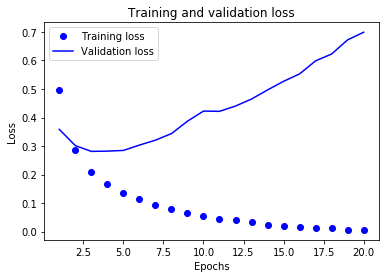

In [22]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

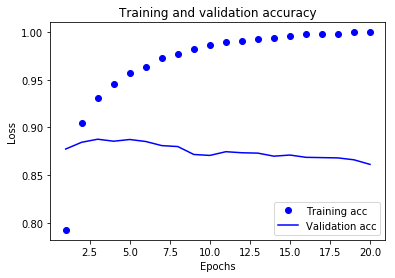

In [24]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Как видите, на этапе обучения потери снижаются с каждой эпохой, а точность
растет. Именно такое поведение ожидается от оптимизации градиентным спу-
ском: величина, которую вы пытаетесь минимизировать, должна становиться
все меньше с каждой итерацией. Но это не относится к потерям и точности на
этапе проверки: похоже, что они достигли пика в четвертую эпоху. Это пример
того, о чем мы предупреждали выше: модель, показывающая хорошие результа-
ты на обучающих данных, не обязательно будет показывать такие же хорошие
результаты на данных, которые не видела прежде. Выражаясь точнее, в данном
случае наблюдается переобучение: после второй эпохи произошла чрезмерная
оптимизация на обучающих данных, и в результате получилось представление,
характерное для обучающих данных, не обобщающее данные за пределами обучающего набора.
В данном случае для предотвращения переобучения можно прекратить обучение
после третьей эпохи. Вообще говоря, есть целый спектр приемов, ослабляющих
эффект переобучения, которые мы рассмотрим далее.

А теперь обучим новую сеть с нуля в течение четырех эпох и затем оценим получившийся результат на контрольных данных.

In [25]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 1s 49us/step - loss: 0.4618 - acc: 0.8237
Epoch 2/4
25000/25000 [==============================] - 1s 42us/step - loss: 0.2588 - acc: 0.9089
Epoch 3/4
25000/25000 [==============================] - 1s 42us/step - loss: 0.1984 - acc: 0.9283
Epoch 4/4
25000/25000 [==============================] - 1s 46us/step


In [26]:
results

[0.3078245770406723, 0.87776]

Это простейшее решение позволило достичь точности 88 %. 

## Использование обученной сети для предсказаний на новых данных

После обучения сети ее можно использовать для решения практических задач.
Например, попробуем предсказать вероятность того, что отзывы будут положи-
тельными, с помощью метода predict :

In [27]:
model.predict(x_test)

array([[0.19616291],
       [0.9998135 ],
       [0.9317017 ],
       ...,
       [0.18852988],
       [0.13945232],
       [0.74792033]], dtype=float32)

Как видите, сеть уверена в одних образцах (0,99 или выше или 0,01 или ниже), но
не так уверена в других (0,6; 0,4).


## Задания


* В данном примере использовались два скрытых слоя. Попробуйте использовать
один или три и посмотрите, как это повлияет на точность на этапах обучения
и проверки.
* Попробуйте использовать слои с большим или с меньшим количеством скрытых
нейронов: 32 нейрона, 64 нейрона и т. д.
* Попробуйте вместо binary_crossentropy использовать функцию потерь mse .
* Попробуйте вместо relu использовать функцию активации tanh (она была популярна на заре становления нейронных сетей).

## Выводы

* Обычно исходные данные приходится подвергать некоторой предварительной
обработке, чтобы передать их в нейронную сеть в виде тензоров. Последователь-
ности слов можно преобразовать в бинарные векторы, но существуют также
другие варианты.
* Стек слоев Dense с функцией активации relu способен решать широкий круг
задач (включая классификацию эмоциональной окраски), и вы, вероятно, чаще
всего будете использовать именно эту комбинацию.
* В задаче бинарной классификации (с двумя выходными классами) в конце
вашей нейросети должен находиться слой Dense с одним нейроном и функцией
активации sigmoid : результатом работы сети должно быть скалярное значение
в диапазоне между 0 и 1, представляющее собой вероятность.
* С таким скалярным результатом, получаемым с помощью сигмоидной функции,
в задачах бинарной классификации следует использовать функцию потерь
binary_crossentropy .
* В общем случае оптимизатор rmsprop является наиболее подходящим выбором
для любого типа задач. Одной головной болью меньше для вас.
* По мере улучшения на обучающих данных нейронные сети рано или поздно
начинают переобучаться, демонстрируя ухудшение результатов на данных, ко-
торые они прежде не видели. Поэтому всегда контролируйте качество работы
сети на данных не из обучающего набора.

